In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error ,r2_score
from sklearn.preprocessing import StandardScaler


In [6]:
#data loading
# Try different encoding methods
try:
    data = pd.read_csv('Amazon_Sale_Report.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        data = pd.read_csv('Amazon_Sale_Report.csv', encoding='latin-1')
    except UnicodeDecodeError:
        try:
            data = pd.read_csv('Amazon_Sale_Report.csv', encoding='ISO-8859-1')
        except UnicodeDecodeError:
            try:
                data = pd.read_csv('Amazon_Sale_Report.csv', encoding='cp1252')
            except UnicodeDecodeError:
                print("None of the tried encodings worked. Please check the file encoding manually.")
                data = None # Or handle the error in a different way


In [7]:
#DATA INSEPECTION
print(data.head())
print(data.info())
print(data.describe())

   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel ship-service-level  Category Size Courier Status  \
0   Merchant     Amazon.in           Standard   T-shirt    S     On the Way   
1   Merchant     Amazon.in           Standard     Shirt  3XL        Shipped   
2     Amazon     Amazon.in          Expedited     Shirt   XL        Shipped   
3   Merchant     Amazon.in           Standard   Blazzer    L     On the Way   
4     Amazon     Amazon.in          Expedited  Trousers  3XL        Shipped   

   ...  currency  Amount    ship-city   ship-state ship-postal-code  \
0  ...       IN

In [8]:
# DATA CLEANING
data.fillna(method='ffill',inplace=True)

<ipython-input-8-e8b4462439c7>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill',inplace=True)


In [9]:
# Convert 'Order Date' to datetime format
data['Date'] =pd.to_datetime(data['Date'])

<ipython-input-9-1be5570da521>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] =pd.to_datetime(data['Date'])


In [10]:
# Create derived columns
data['Revenue']=data['Qty']* data['Amount']
data['Year']=data['Date'].dt.year
data['Month']=data['Date'].dt.month
data['Day']=data['Date'].dt.day

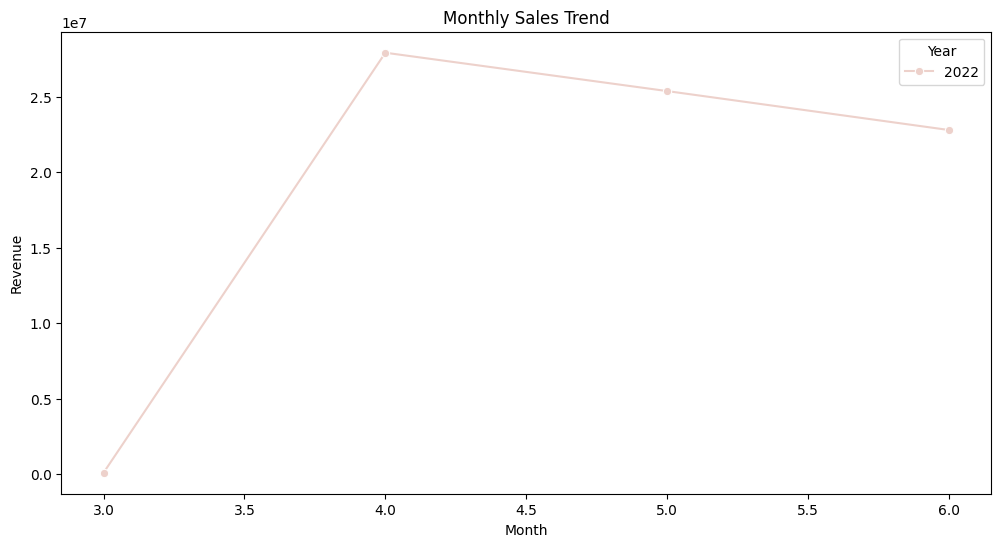

In [11]:
# Step 4: Sales Overview
# Sales trend by month and year
monthly_sales = data.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Revenue', hue='Year', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

<ipython-input-12-5fa3e97760cb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


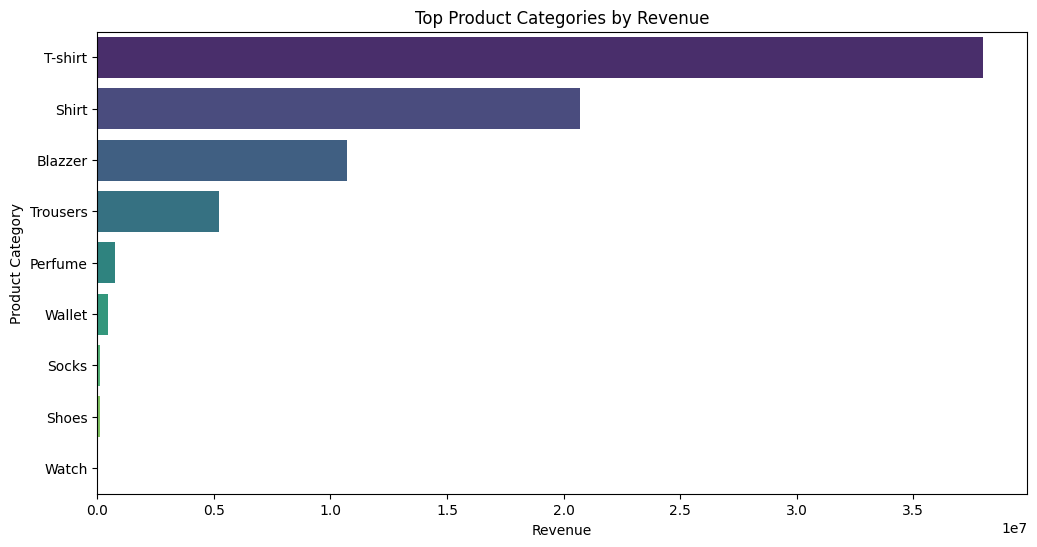

In [12]:
#Step 5: Product Analysis
# Top product categories by revenue
top_categories = data.groupby('Category')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top Product Categories by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product Category')
plt.show()

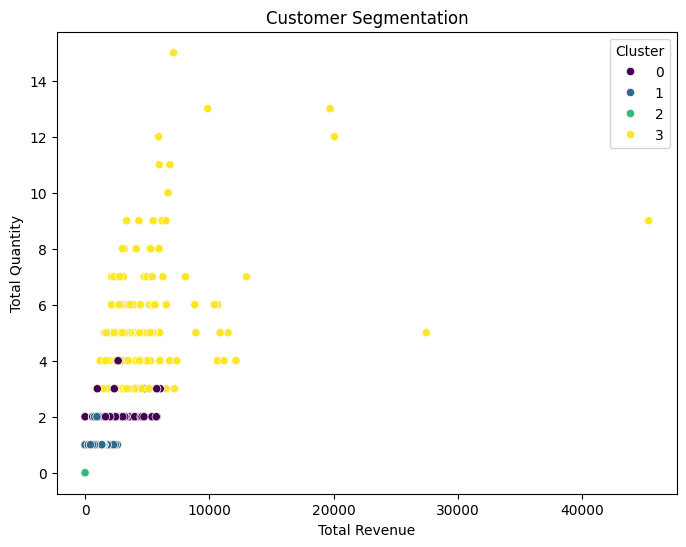

In [13]:
#Customer Segmentation
customer_data = data.groupby('Order ID').agg({
    'Revenue': 'sum',
    'Qty': 'sum',
    'Date': 'count'
}).rename(columns={'Order Date': 'Order Frequency'})

scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_data)

kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_data['Revenue'], y=customer_data['Qty'], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Total Revenue')
plt.ylabel('Total Quantity')
plt.show()

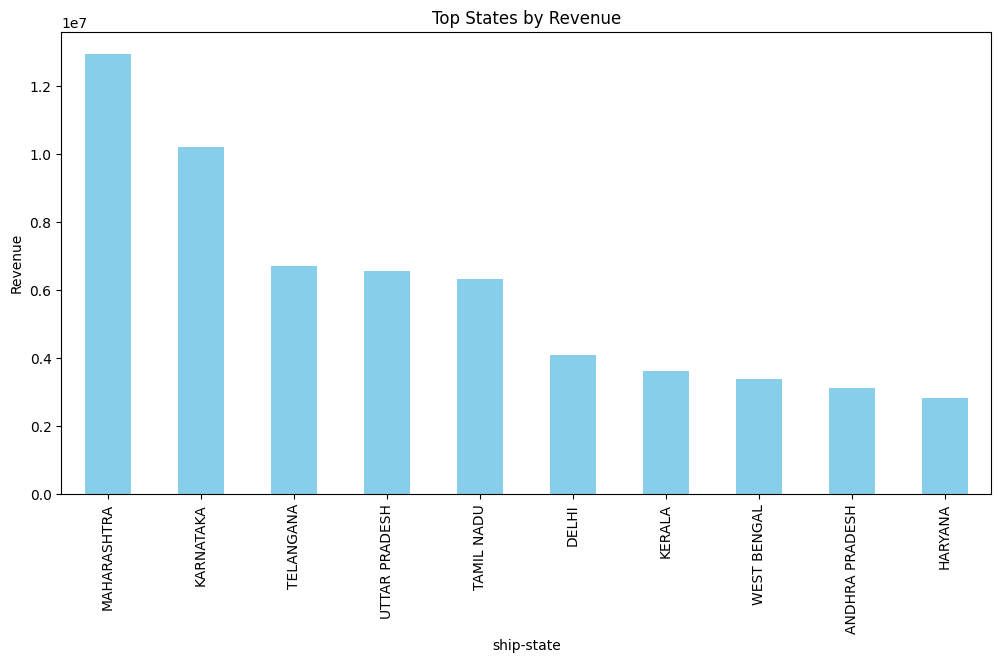

In [14]:
#Geographical Analysis
geo_data = data.groupby(['ship-state', 'ship-city']).agg({
    'Revenue': 'sum',
    'Qty': 'sum'
}).reset_index()

top_states = geo_data.groupby('ship-state')['Revenue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='skyblue', title='Top States by Revenue')
plt.ylabel('Revenue')
plt.show()

<ipython-input-17-520a4af94bb5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fulfillment_data, x='Fulfilment', y='Revenue', palette='coolwarm')  # Column names must match


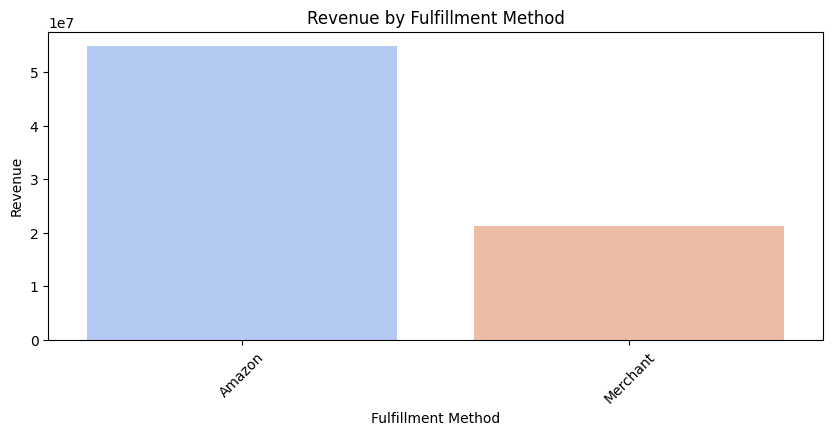

In [17]:
# Fulfillment Analysis
fulfillment_data = data.groupby('Fulfilment')['Revenue'].sum().reset_index()  # Ensure this matches the dataset
plt.figure(figsize=(10, 4))
sns.barplot(data=fulfillment_data, x='Fulfilment', y='Revenue', palette='coolwarm')  # Column names must match
plt.title('Revenue by Fulfillment Method')
plt.xlabel('Fulfillment Method')
plt.ylabel('Revenue')
plt.xticks(rotation=45)  # Rotate labels for clarity
plt.show()


<ipython-input-16-5c10ac34be96>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fulfillment, x='Fulfilment', y='Revenue', palette='coolwarm')  # Ensure column names match here too


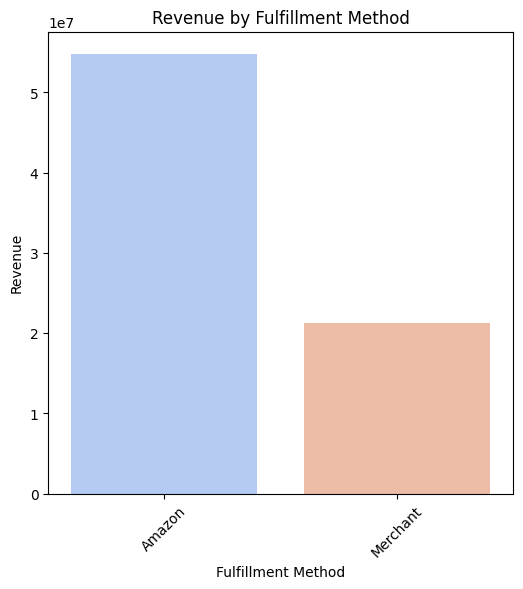

In [16]:
# Fulfillment Analysis with adjusted figure size
fulfillment = data.groupby('Fulfilment')['Revenue'].sum().reset_index()  # Ensure column names match the dataset

# Adjust figure size based on the data
num_fulfillment_methods = len(fulfillment)  # Get the count of fulfillment methods
fig_width = 2 + num_fulfillment_methods * 2  # Dynamically adjust width
fig_height = 6  # Fixed height for readability

plt.figure(figsize=(fig_width, fig_height))
sns.barplot(data=fulfillment, x='Fulfilment', y='Revenue', palette='coolwarm')  # Ensure column names match here too
plt.title('Revenue by Fulfillment Method')
plt.xlabel('Fulfillment Method')
plt.ylabel('Revenue')
plt.xticks(rotation=45)  # Rotate labels for clarity if necessary
plt.show()


In [43]:
#Sales Prediction
sales_data = data[['Year', 'Month', 'Qty', 'Amount', 'Revenue']]
X = sales_data[['Year', 'Month', 'Qty', 'Amount']]
y = sales_data['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Model Evaluation
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))

Mean Squared Error: 77.81531041634366
R-squared Score: 0.9993826322982162


<ipython-input-44-6d2121d9bf13>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=importances, palette='viridis')


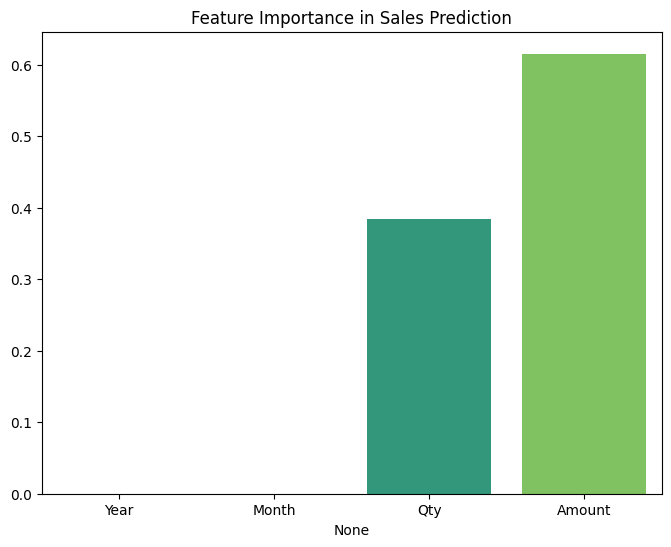

In [44]:
# Feature Importance
importances = rf_model.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=X.columns, y=importances, palette='viridis')
plt.title('Feature Importance in Sales Prediction')
plt.show()

Mean Absolute Error: 63027.39299411765


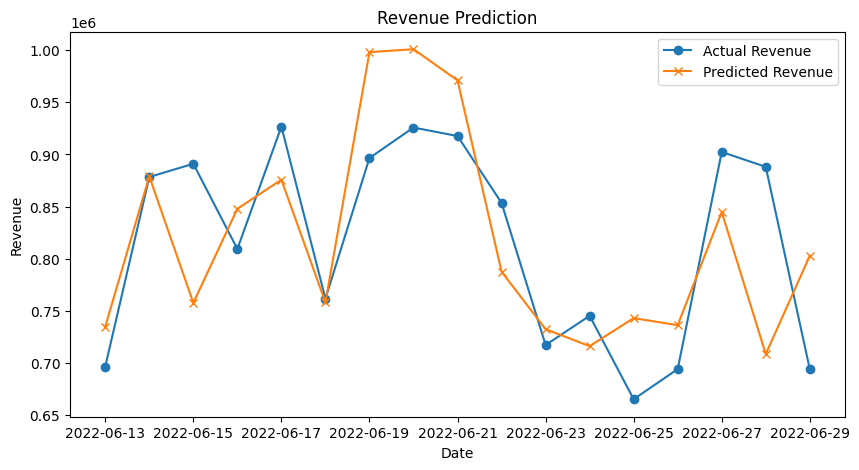

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Load data


# Preprocessing
data['Date'] = pd.to_datetime(data['Date'])  # Ensure the date column is in datetime format
data = data.sort_values('Date')  # Sort data by date

# Aggregate revenue by date
daily_revenue = data.groupby('Date')['Revenue'].sum().reset_index()

# Feature engineering
daily_revenue['Day'] = daily_revenue['Date'].dt.day
daily_revenue['Month'] = daily_revenue['Date'].dt.month
daily_revenue['Year'] = daily_revenue['Date'].dt.year

# Lag features
daily_revenue['Lag_1'] = daily_revenue['Revenue'].shift(1)
daily_revenue['Lag_7'] = daily_revenue['Revenue'].shift(7)
daily_revenue = daily_revenue.dropna()  # Remove rows with NaN values after lagging

# Train-test split
X = daily_revenue[['Day', 'Month', 'Year', 'Lag_1', 'Lag_7']]
y = daily_revenue['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(daily_revenue['Date'][-len(y_test):], y_test, label='Actual Revenue', marker='o')
plt.plot(daily_revenue['Date'][-len(y_test):], y_pred, label='Predicted Revenue', marker='x')
plt.title('Revenue Prediction')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 63027.39
R² Score: 0.31


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Metrics Calculation
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print Metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Optional: Display R² as accuracy in percentage
accuracy = r2 * 100
print(f"Prediction Accuracy (R² as %): {accuracy:.2f}%")


Mean Absolute Error (MAE): 63027.39
Mean Squared Error (MSE): 6047882944.28
Root Mean Squared Error (RMSE): 77768.14
R² Score: 0.31
Prediction Accuracy (R² as %): 31.07%
